In [101]:
import nilearn
import sklearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img,math_img,index_img,concat_imgs
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.input_data import NiftiMasker

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from nilearn.decoding import Decoder 
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

import time

import numpy as np
import pandas as pd
import os


In [75]:
# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
#ROOT_DATA='/home/brunomiguel/Documents/data/BIDS/'
SUB='sub-0001'
SES='ses-001'
TASK='innerspeech'
RUN=['run-01','run-02','run-03']

# project folder
ROOT_PROJECT="/Volumes/LANGLYBACKU/MVPA_Speech_project"



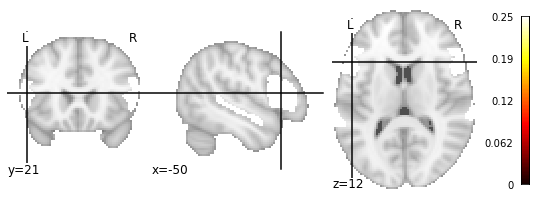

In [77]:
# mask selection
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps

area_idx=[47,48]
area_idx=[5,6]
area_idx=[9,10, 5, 6]

mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in area_idx])
plotting.plot_stat_map(mask)


mask_fn=os.path.join(SUB + '_' + SES + '_task-' + TASK + '_'+ RUN[0] +'_mask.nii.gz')
mask= image.load_img(mask_fn)

masker=NiftiMasker(mask_img=mask, standardize=True)

In [78]:
dataset

{'maps': 'C:\\Users\\bdireito/nilearn_data\\fsl\\data\\atlases\\HarvardOxford\\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
 'labels': ['Background',
  'Frontal Pole',
  'Insular Cortex',
  'Superior Frontal Gyrus',
  'Middle Frontal Gyrus',
  'Inferior Frontal Gyrus, pars triangularis',
  'Inferior Frontal Gyrus, pars opercularis',
  'Precentral Gyrus',
  'Temporal Pole',
  'Superior Temporal Gyrus, anterior division',
  'Superior Temporal Gyrus, posterior division',
  'Middle Temporal Gyrus, anterior division',
  'Middle Temporal Gyrus, posterior division',
  'Middle Temporal Gyrus, temporooccipital part',
  'Inferior Temporal Gyrus, anterior division',
  'Inferior Temporal Gyrus, posterior division',
  'Inferior Temporal Gyrus, temporooccipital part',
  'Postcentral Gyrus',
  'Superior Parietal Lobule',
  'Supramarginal Gyrus, anterior division',
  'Supramarginal Gyrus, posterior division',
  'Angular Gyrus',
  'Lateral Occipital Cortex, superior division',
  'Lateral Occipital Cor

In [79]:
bs_maps=None
classification_target=None

for r in RUN:
    
    # Load data
    bs_fn=os.path.join(SUB + '_' + SES + '_task-' + TASK + '_'+ r +'_bold_bs.nii.gz')
    bs_map= image.load_img(bs_fn)
    
    
    # Mask data
    # masker=NiftiMasker(mask_img=mask, standardize=True)
    # mask_timecourse=masker.fit_transform(bs_maps)
    
    # Load labels
    labels_fn=os.path.join(SUB + '_' + SES + '_task-' + TASK + '_'+ r +'_labels.csv')
    col_list = ["0"]
    labels=pd.read_csv(labels_fn, usecols=col_list)
    
    
    if bs_maps is None:
        bs_maps=bs_map
        classification_target=labels
    else:
        bs_maps=[bs_maps,bs_map]
        classification_target=np.vstack((classification_target, labels))
    
    del bs_map,labels


In [80]:
bs_maps=concat_imgs(bs_maps, auto_resample=True)
print(bs_maps.shape)

(91, 109, 91, 756)


In [103]:
target_tags=['Baseline', 'Syllables', 'Words', 'Phrases', 'Vogals']

# Here we compute prediction scores and run time for all these
# classifiers
classifiers = ['svc_rbf']

cv = 5
classifiers_data = {}
mask_timecourse=masker.fit_transform(bs_maps)

X_train, X_test, y_train, y_test = train_test_split(mask_timecourse, classification_target, test_size=0.2, random_state=10)

In [104]:
for classifier_name in classifiers:
    print(70 * '_')

    ## TRAIN
   
    decoder = SVC(kernel='rbf')

    t0 = time.time()
    decoder.fit(X_train, y_train)

    classifiers_data[classifier_name] = {}
    
    classifiers_data[classifier_name]['train_score'] = cross_val_score(decoder, mask_timecourse, classification_target, cv=cv, scoring='accuracy')

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    print(classifiers_data)
    
    ## TESTE
    
    classifiers_data[classifier_name]['test_score'] =decoder.score(X_test, y_test)
    




______________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

    svc_l1: 16.65s
{'svc_l1': {'train_score': array([0.31578947, 0.30463576, 0.31788079, 0.32450331, 0.26490066])}}


In [107]:
decoder.predict(X_test)

array(['Phrases', 'Baseline', 'Baseline', 'Baseline', 'Baseline',
       'Baseline', 'Phrases', 'Baseline', 'Baseline', 'Baseline', 'Words',
       'Baseline', 'Baseline', 'Syllables', 'Phrases', 'Syllables',
       'Baseline', 'Baseline', 'Phrases', 'Baseline', 'Vogals',
       'Syllables', 'Baseline', 'Baseline', 'Baseline', 'Words',
       'Baseline', 'Baseline', 'Syllables', 'Syllables', 'Vogals',
       'Syllables', 'Baseline', 'Vogals', 'Syllables', 'Baseline',
       'Phrases', 'Syllables', 'Baseline', 'Words', 'Vogals', 'Baseline',
       'Words', 'Baseline', 'Baseline', 'Vogals', 'Baseline', 'Baseline',
       'Phrases', 'Syllables', 'Words', 'Baseline', 'Baseline',
       'Baseline', 'Baseline', 'Vogals', 'Phrases', 'Baseline',
       'Baseline', 'Vogals', 'Baseline', 'Vogals', 'Words', 'Baseline',
       'Vogals', 'Baseline', 'Phrases', 'Syllables', 'Baseline',
       'Syllables', 'Baseline', 'Baseline', 'Baseline', 'Baseline',
       'Baseline', 'Phrases', 'Syllables', 'Bas

In [108]:
y_test

array([['Phrases'],
       ['Baseline'],
       ['Vogals'],
       ['Baseline'],
       ['Baseline'],
       ['Baseline'],
       ['Phrases'],
       ['Baseline'],
       ['Baseline'],
       ['Phrases'],
       ['Words'],
       ['Baseline'],
       ['Vogals'],
       ['Syllables'],
       ['Phrases'],
       ['Baseline'],
       ['Baseline'],
       ['Baseline'],
       ['Phrases'],
       ['Phrases'],
       ['Vogals'],
       ['Syllables'],
       ['Syllables'],
       ['Baseline'],
       ['Words'],
       ['Baseline'],
       ['Words'],
       ['Baseline'],
       ['Syllables'],
       ['Syllables'],
       ['Vogals'],
       ['Syllables'],
       ['Baseline'],
       ['Vogals'],
       ['Syllables'],
       ['Baseline'],
       ['Phrases'],
       ['Syllables'],
       ['Baseline'],
       ['Words'],
       ['Vogals'],
       ['Words'],
       ['Words'],
       ['Baseline'],
       ['Phrases'],
       ['Vogals'],
       ['Words'],
       ['Vogals'],
       ['Phrases'],
       ['

In [ ]:
with open('area_comparison.txt', 'a+') as f:
    print(area_idx,file=f)
    print(classifiers_data,file=f)

## Comparison with Dummy predictor

In [88]:
from sklearn.dummy import DummyClassifier

for classifier_name in classifiers:
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = DummyClassifier(strategy='uniform')
    
    t0 = time.time()
    decoder.fit(mask_timecourse, classification_target)

    classifiers_data[classifier_name] = {}
    
    classifiers_data[classifier_name]['score'] = cross_val_score(decoder, mask_timecourse, classification_target, cv=cv, scoring='accuracy')

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    print(classifiers_data)
   

______________________________________________________________________
    svc_l1: 0.03s
{'svc_l1': {'score': array([0.17105263, 0.16556291, 0.19205298, 0.19205298, 0.19205298])}}


In [89]:
null_cv_scores = cross_val_score(
    DummyClassifier(),mask_timecourse, classification_target, cv=cv)
print(null_cv_scores)

[0.21052632 0.20529801 0.22516556 0.20529801 0.21854305]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
